In [1]:
# source /data/Xilinx_no_Vitis/Vivado/2020.1/settings64.sh
!vivado -version

Vivado v2020.1.1 (64-bit)
SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.


In [23]:
import os 
import pickle
import hashlib

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy 

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
keras.utils.set_random_seed(812)

## Setup data

In [5]:
train_data_dir = "../data/malab_05282024/npz/"
test_data_dir = "../data/malab_05282024/npz/"
start_location = 100
window_size = 400
end_window = start_location + window_size # 500

In [6]:
"""Loadning training split"""
x_train_path = os.path.join(train_data_dir, f'0528_X_train_0_770.npy')
y_train_path = os.path.join(train_data_dir, f'0528_y_train_0_770.npy')

assert os.path.exists(x_train_path), f"ERROR: File {x_train_path} does not exist."
assert os.path.exists(y_train_path), f"ERROR: File {y_train_path} does not exist."

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_train_val = X_train_val[:,start_location*2:end_window*2]
assert len(X_train_val[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_train_val[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Train Data Set:")
print(f"  X Path : {x_train_path}")
print(f"  y Path : {y_train_path}")
print(f"  Size : {len(X_train_val):,}")
print(f"  Shape : {X_train_val[0].shape}")

Train Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_train_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_train_0_770.npy
  Size : 900,000
  Shape : (800,)


In [7]:
"""Loading testing split"""
x_test_path = os.path.join(test_data_dir, f'0528_X_test_0_770.npy')
y_test_path = os.path.join(test_data_dir, f'0528_y_test_0_770.npy')

assert os.path.exists(x_test_path), f"ERROR: File {x_test_path} does not exist."
assert os.path.exists(y_test_path), f"ERROR: File {y_test_path} does not exist."

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

# Get readout window
X_test = X_test[:,start_location*2:end_window*2]
assert len(X_test[0]) == (end_window-start_location)*2, f"ERROR: X_test sample size {len(X_test[0])} does not match (start window, end window) ({start_location},{end_window}) size."


print("Test Data Set:")
print(f"  X Path : {x_test_path}")
print(f"  y Path : {y_test_path}")
print(f"  Size : {len(X_test):,}" )
print(f"  Sample Shape : {X_test[0].shape}")

Test Data Set:
  X Path : ../data/malab_05282024/npz/0528_X_test_0_770.npy
  y Path : ../data/malab_05282024/npz/0528_y_test_0_770.npy
  Size : 100,000
  Sample Shape : (800,)


## Build our model 
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [8]:
hidden_neurons = 4
input_shape = int((end_window-start_location)*2)

In [9]:
def get_model(input_shape, hidden=8, is_pruned=True):
    model = keras.models.Sequential()
    model.add(QDense(
        hidden, 
        activation='relu', 
        name='fc1',
        input_shape=(input_shape,), 
        kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1)
    ))
    model.add(QBatchNormalization(
            name='batchnorm1',
            gamma_quantizer=quantized_bits(6, 0, 1),
            mean_quantizer=quantized_bits(6, 0, 1),
            variance_quantizer=quantized_bits(6, 0, 1),
            beta_quantizer=quantized_bits(6, 0, 1),
    ))
    model.add(
        QDense(1, name='fc2', activation='sigmoid', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1))
    )

    if is_pruned == True:
        # adding pruning 
        pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10, final_sparsity=0.50, begin_step=100, end_step=1000)}
        model = prune.prune_low_magnitude(model, **pruning_params)
    return model


model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=False)
print(model.summary())
print('Input shape:', input_shape)
print('Number of hidden neurons:', hidden_neurons)

2024-10-02 16:19:46.434123: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-02 16:19:46.434168: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-02 16:19:46.434203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-10-02 16:19:46.434556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 4)                 3204      
                                                                 
 batchnorm1 (QBatchNormaliza  (None, 4)                16        
 tion)                                                           
                                                                 
 fc2 (QDense)                (None, 1)                 5         
                                                                 
Total params: 3,225
Trainable params: 3,217
Non-trainable params: 8
_________________________________________________________________
None
Input shape: 800
Number of hidden neurons: 4


## Training 

In [10]:
init_learning_rate = 1e-3
validation_split = 0.05  # 45,000 sample size 
batch_size = 256
epochs = 10
early_stopping_patience = 20
checkpoint_dir = f'../checkpoints/scan_window_location_and_size_h{hidden_neurons}'
checkpoint_filename = 'qkeras_model_best.h5'

if os.path.exists(checkpoint_dir) == False:
    print(f'Checkpoint directory {checkpoint_dir} does not exist.')
    print('Creating directory...')
    os.mkdir(checkpoint_dir)

In [11]:
#########################
# 0. init callbacks
#########################
ckp_dir = os.path.join(checkpoint_dir, f'sl{start_location}_ws{window_size}')
if os.path.exists(ckp_dir) == False: os.mkdir(ckp_dir)
print('Saving to', ckp_dir)

ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
callbacks = [
    ModelCheckpoint(
        ckp_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        save_freq="epoch",
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=False,
    ),
]


Saving to ../checkpoints/scan_window_location_and_size_h4/sl100_ws400


In [12]:
if True:
    #########################
    # 1. declare model 
    #########################
    opt = Adam(learning_rate=init_learning_rate)
    model = get_model(input_shape=window_size*2, hidden=hidden_neurons, is_pruned=False)
    model.compile(
        optimizer=opt, 
        loss=BinaryCrossentropy(from_logits=False), 
        metrics=['accuracy']
    )

    #########################
    # 3. train 
    #########################
    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=batch_size,
        epochs=epochs, 
        validation_split=validation_split, 
        shuffle=True, 
        callbacks=callbacks,
    )

    # Save the history dictionary
    with open(os.path.join(ckp_dir, 'qkeras_training_history.pkl'), 'wb') as f:
        pickle.dump(history.history, f)

    #########################
    # 3. compute fidelity 
    #########################
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, np.where(y_pred <= 0.5, 0, 1).reshape(-1))

    print('\n===================================')
    print(f'Start location = {start_location}, Window size = {window_size}')
    print('    Accuracy', test_acc)
    print('    Fidelity', test_acc*2-1)


2024-10-02 16:20:11.992760: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2736000000 exceeds 10% of free system memory.


Epoch 1/10
3338/3340 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9529

2024-10-02 16:20:28.771610: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 144000000 exceeds 10% of free system memory.


3340/3340 [==============================] - 16s 4ms/step - loss: 0.1932 - accuracy: 0.9529 - val_loss: 0.1867 - val_accuracy: 0.9548
Epoch 2/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1841 - accuracy: 0.9549 - val_loss: 0.1855 - val_accuracy: 0.9534
Epoch 3/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1836 - accuracy: 0.9553 - val_loss: 0.1859 - val_accuracy: 0.9549
Epoch 4/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1831 - accuracy: 0.9556 - val_loss: 0.1857 - val_accuracy: 0.9548
Epoch 5/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1827 - accuracy: 0.9561 - val_loss: 0.1862 - val_accuracy: 0.9559
Epoch 6/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1822 - accuracy: 0.9565 - val_loss: 0.1858 - val_accuracy: 0.9558
Epoch 7/10
3340/3340 [==============================] - 14s 4ms/step - loss: 0.1820 - accuracy: 0.9568 - val_loss: 0.1857 - val_accuracy: 0.9

2024-10-02 16:22:37.847899: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 320000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 3s 921us/step

Start location = 100, Window size = 400
    Accuracy 0.95624
    Fidelity 0.91248


## Check performance

In [13]:
ckp_filename = os.path.join(ckp_dir, checkpoint_filename)
ckp_filename

'../checkpoints/scan_window_location_and_size_h4/sl100_ws400/qkeras_model_best.h5'

In [14]:
checkpoint_model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=False)
checkpoint_model.load_weights(ckp_filename)

y_pred = checkpoint_model.predict(X_test)
test_acc = accuracy_score(y_test, np.where(y_pred < 0.5, 0, 1).reshape(-1))

print(f"Keras  Accuracy: {test_acc}")
print(f"Keras  Fidelity: {test_acc*2-1}")

2024-10-02 16:25:25.097627: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 320000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 3s 947us/step
Keras  Accuracy: 0.95604
Keras  Fidelity: 0.91208


## Check sparsity 

Number of layers: 3
% of zeros = 0.0
% of zeros = 0.0
% of zeros = 0.0


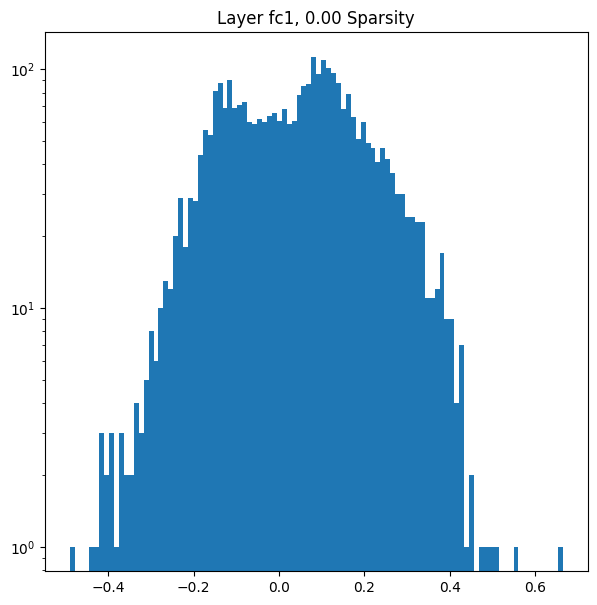

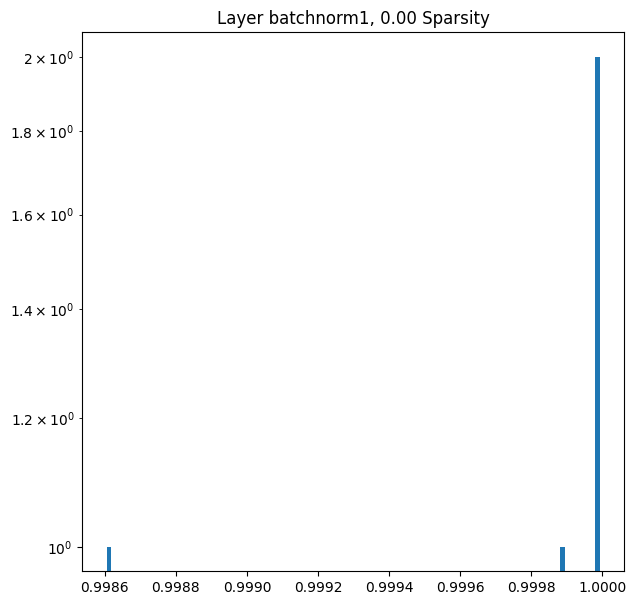

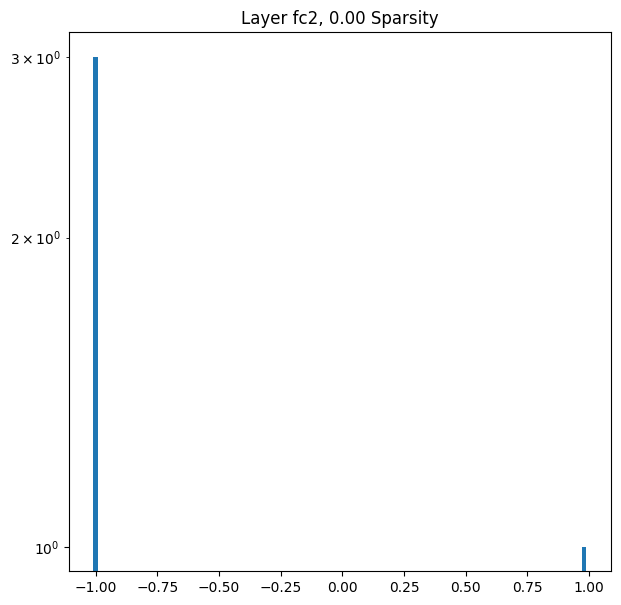

In [15]:
num_layers = len(checkpoint_model.layers)
print(f'Number of layers: {num_layers}')


for idx in range(num_layers):
    w = checkpoint_model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)
    layer_sparsity = np.sum(w == 0) / np.size(w)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.title(f'Layer {checkpoint_model.layers[idx].name}, {layer_sparsity:.2f} Sparsity')
    plt.savefig(os.path.join(ckp_dir, f'model-dist-idx{idx}.png'))
    print('% of zeros = {}'.format(layer_sparsity))


checkpoint_model = strip_pruning(checkpoint_model)  # remove prune layers for hls4ml parsing 
checkpoint_model.save_weights(ckp_filename)  # save as weights only for keras tracing (cannot directly pass strip_pruned model)
checkpoint_model = get_model(input_shape=input_shape, hidden=hidden_neurons, is_pruned=False)
checkpoint_model.load_weights(ckp_filename)

## HLS4ML

In [16]:
import sys 
sys.path.append("../utils")
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [17]:
# Create HLS configuration 
hls_config = {}
hls_config['Model'] = {}
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
hls_config['Model']['ReuseFactor'] = 64  # fully parallelized 
hls_config['Model']['Strategy'] = 'Resource'

hls_config['LayerName'] = {}
keras_layers = ['fc1', 'fc1_relu', 'batchnorm1', 'fc2', 'fc2_sigmoid']
for layer in keras_layers:
    hls_config['LayerName'][layer] = {}
    hls_config['LayerName'][layer]['Precision'] = {}
    hls_config['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
hls_config['LayerName']['fc1_input'] = {}
hls_config['LayerName']['fc1_input']['Precision'] = {}
hls_config['LayerName']['fc1_input']['Trace'] = False
hls_config['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc1
hls_config['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<18,17>'
hls_config['LayerName']['fc1']['accum_t'] = 'ap_fixed<18,17>'

# Fc1 activation 
hls_config['LayerName']['fc1_relu']['Precision']['result'] = 'ap_fixed<18,17>'

# Batchnormalization
hls_config['LayerName']['batchnorm1']['Precision']['scale'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['bias'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['Precision']['result'] = 'ap_fixed<24,4>'
hls_config['LayerName']['batchnorm1']['accum_t'] = 'ap_fixed<24,4>'

# Fc2
hls_config['LayerName']['fc2']['Precision']['result'] = 'ap_fixed<8,5>'
hls_config['LayerName']['fc2']['accum_t'] = 'ap_fixed<8,5>'

# Fc2 activation 
hls_config['LayerName']['fc2_sigmoid']['Precision']['result'] = 'ap_fixed<8,1>'

print_dict(hls_config)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       64
  Strategy:          Resource
LayerName
  fc1
    Precision
      result:        ap_fixed<18,17>
    Trace:           True
    accum_t:         ap_fixed<18,17>
  fc1_relu
    Precision
      result:        ap_fixed<18,17>
    Trace:           True
  batchnorm1
    Precision
      scale:         ap_fixed<24,4>
      bias:          ap_fixed<24,4>
      result:        ap_fixed<24,4>
    Trace:           True
    accum_t:         ap_fixed<24,4>
  fc2
    Precision
      result:        ap_fixed<8,5>
    Trace:           True
    accum_t:         ap_fixed<8,5>
  fc2_sigmoid
    Precision
      result:        ap_fixed<8,1>
    Trace:           True
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           False


### Build HLS model 

In [18]:
output_dir = f'../hls4ml_projects/sl-{start_location}_ws-{window_size}_hn-{hidden_neurons}'
xilinx_part = 'xczu49dr-ffvf1760-2-e'
io_type = 'io_parallel'
clock_period = 3.225  # 3.225ns (307.2 MHz)
hls_fig = os.path.join(output_dir, 'model.png')
backend = 'VivadoAccelerator' 
interface = 'axi_stream'
#driver = 'c'
board = 'zcu216'

In [19]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model=checkpoint_model,
    hls_config=hls_config,
    output_dir=output_dir,
    part=xilinx_part,
    io_type=io_type,
    clock_period=clock_period,
    backend=backend,
    board=board,
    interface=interface,
    #driver=driver,
    project_name='NN'
)

print(f"Creating hls4ml project directory {output_dir}")
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=hls_fig 
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 800]], output shape: [None, 800]
Layer name: fc1, layer type: QDense, input shapes: [[None, 800]], output shape: [None, 4]
Layer name: batchnorm1, layer type: QBatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 1]
Creating HLS model
Creating hls4ml project directory ../hls4ml_projects/sl-100_ws-400_hn-4
Writing HLS project


Done


## Check performance

In [20]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 

keras_acc = accuracy_score(y_test, np.where(y_pred < 0.5, 0, 1).reshape(-1))
hls_acc = accuracy_score(y_test, np.where(y_hls < 0.5, 0, 1).reshape(-1))

print(f'Keras Acc: {keras_acc*100:.5}%')
print(f'Keras Fidelity: {(keras_acc*2-1) * 100:.5}%')
print(f'HLS Acc: {hls_acc*100:.5}:%')
print(f'HLS Fidelity: {(hls_acc*2-1) * 100:.5}:%')

Keras Acc: 95.604%
Keras Fidelity: 91.208%
HLS Acc: 90.28:%
HLS Fidelity: 80.56:%


### Collect traces and compare

In [21]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(checkpoint_model, X_test) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling NN with tracing
Writing HLS project


Done
  46/3125 [..............................] - ETA: 3s  

2024-10-02 16:26:16.964026: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 320000000 exceeds 10% of free system memory.


3125/3125 [==============================] - 3s 939us/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1', 'fc1_relu', 'batchnorm1', 'fc2', 'fc2_sigmoid'])
Keras Keys: dict_keys(['fc1', 'fc2', 'fc1_relu', 'batchnorm1', 'fc2_sigmoid'])


Layer(s): fc1 		 164.39969
hls/keras min: -31634.5/-31469.4375
hls/keras max: 35151.5/35321.25
Layer(s): fc1_relu 		 84.28131
hls/keras min: 0.0/0.0
hls/keras max: 35151.5/35321.25
Layer(s): batchnorm1 		 0.8577395
hls/keras min: -1.1879234313964844/-0.2814232110977173
hls/keras max: 4.466338157653809/5.2818379402160645
Layer(s): fc2 		 1.4555049
hls/keras min: -9.0/-10.180303573608398
hls/keras max: 7.75/6.2109880447387695
Layer(s): fc2_sigmoid 		 0.08484008
hls/keras min: 0.0/3.790826303884387e-05
hls/keras max: 0.9921875/0.9979967474937439


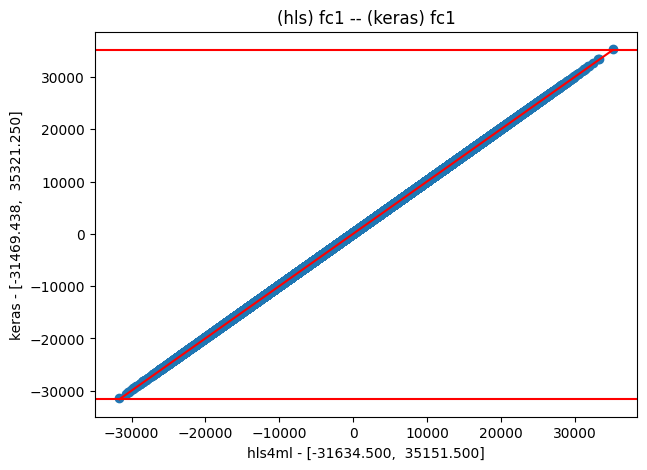

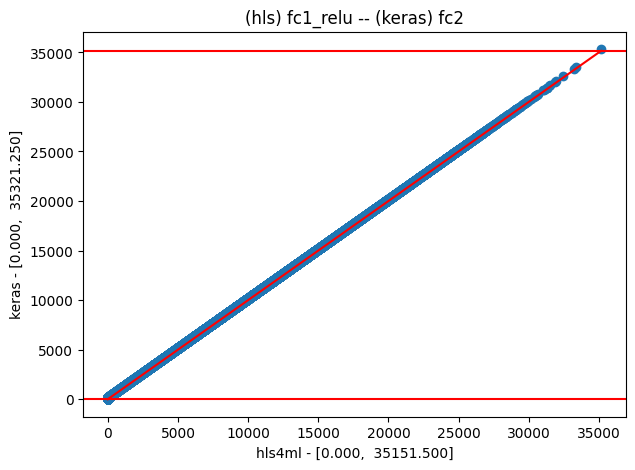

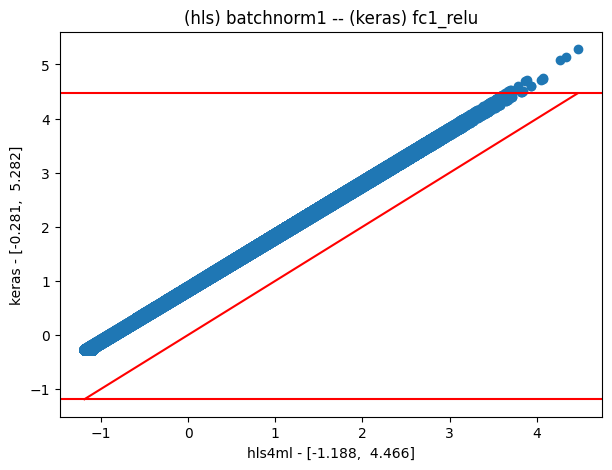

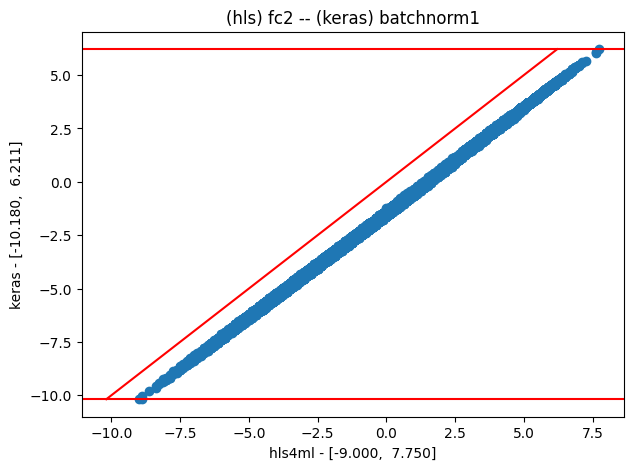

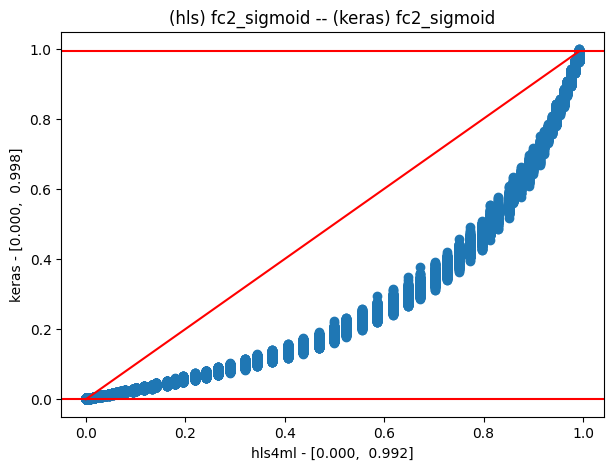

In [22]:
idx = 0

hls_layers = hls_trace.keys()
keras_layers = list(keras_trace.keys())

for layer in hls_trace.keys():
    keras_layer = layer 
    hls_layer = layer 
    keras_layer, hls_layer = keras_trace[keras_layer], hls_trace[hls_layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'Layer(s): {list(hls_trace.keys())[idx]}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {list(hls_trace.keys())[idx]} -- (keras) {list(keras_trace.keys())[idx]}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
        idx += 1
    except Exception as e:
        print(e)


## Synthesize 

In [33]:
hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=False,
    vsynth=True,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jcampos' on host 'correlator4.fnal.gov' (Linux_x86_64 version 5.14.0-427.33.1.el9_4.x86_64) on Fri Sep 20 13:30:01 CDT 2024
INFO: [HLS 200-10] On os "AlmaLinux release 9.4 (Shamrock Pampas Cat)"
INFO: [HLS 200-10] In directory '/data/jcampos/projects/ml-quantum-readout/hls4ml_projects/sl-100_ws-400'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/data/jcampos/projects/ml-quantum-readout/hls4ml_projects/sl-100_ws-400/NN_prj'.
INFO: [HLS 200-10] Adding design file 'firmwa

{'CSynthesisReport': {'TargetClockPeriod': '3.22',
  'EstimatedClockPeriod': '2.768',
  'BestLatency': '896',
  'WorstLatency': '898',
  'IntervalMin': '897',
  'IntervalMax': '899',
  'BRAM_18K': '22',
  'DSP': '129',
  'FF': '175582',
  'LUT': '195887',
  'URAM': '0',
  'AvailableBRAM_18K': '2160',
  'AvailableDSP': '4272',
  'AvailableFF': '850560',
  'AvailableLUT': '425280',
  'AvailableURAM': '80'}}

## Check the report

In [34]:
hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in ../hls4ml_projects/sl-100_ws-400/NN_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'NN_axi'
* Date:           Fri Sep 20 12:47:18 2024

* Version:        2020.1.1 (Build 2951007 on Wed Aug 05 23:24:06 MDT 2020)
* Project:        NN_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu49dr-ffvf1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 3.22 ns | 2.768 ns |   0.40 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max   |    min   |    max   | min | max |   Type  |
    +---------+---------+----------+----